<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/evaluation_notebooks/Extended_Model_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 938, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 938 (delta 96), reused 198 (delta 92), pack-reused 736
Receiving objects: 100% (938/938), 291.80 MiB | 22.77 MiB/s, done.
Resolving deltas: 100% (432/432), done.
Checking out files: 100% (547/547), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents
!ls

base_model.py	LICENSE		      README.md
data		model_loader.py       saved_models
data_reader.py	output_dataframe.pkl  security_plotter.py


In [4]:
import os
import sys
import keras
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
from keras import backend as K
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter
# import Trained_Model class from model_loader module
from feeder_repo.model_loader import Trained_Model

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 30 12:34:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Finding the best performing models
The results dataframe, created from the './evaluation_notebooks/Model_Evaluation_and_Multi_Plotting.ipynb' notebook is used to generate a dictionary of key:value pairs, with one entry per security as the key, and the corresponding value being a string of the model that achieved the lowest MSE.

In [7]:
# storing a list of securities
security_list = ['Al', 'Cu', 'Corn',
                'EURCHF', 'EURUSD', 'GBPUSD',
                'Gilt10y', 'Bund10y', 'Treasury10y',
                'Amazon', 'Google', 'Nvidia']

In [8]:
# loading the results dataframe
output_df = pd.read_pickle('./output_dataframe.pkl')

In [9]:
optimal_dict = {}

# a loop to get the best model for each security, based on MSE minimisation
for s in security_list:
  # creating a new dataframe with only entries relevant to that security
  sec_df = output_df[output_df.Security == s]
  # finding the smallest MSE value
  #min_mse = sec_df.MSE.min()
  # finding the model that achieved the best MSE, converting to string and removing whitespace
  best_mod = sec_df.Model[sec_df.MSE == sec_df.MSE.min()].to_string(index=False).strip()
  # assigning new key:value pair to optimal_dict
  optimal_dict[s] = best_mod

optimal_dict

{'Al': 'LSTM_GRU',
 'Amazon': 'GRU_LSTM',
 'Bund10y': 'GRU_AE',
 'Corn': 'GRU',
 'Cu': 'LSTM_AE',
 'EURCHF': 'GRU_AE',
 'EURUSD': 'LSTM_GRU',
 'GBPUSD': 'LSTM',
 'Gilt10y': 'GRU_LSTM',
 'Google': 'GRU',
 'Nvidia': 'GRU_LSTM',
 'Treasury10y': 'LSTM_GRU'}

# Looping through each of the best performing models
A loop is employed to move through each security, loading the best performing model, removing the final Dense layer and adding in a new Dense layer of 'ouput_len' size to extend the prediction horizon. The predictions are then plotted and saved.

In [10]:
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [11]:
# storing the year of the time series to be used as test data
in_yr = 2019
# setting our window_length to be 30 days
window_len = 30
# setting our prediction length to be 15 days
output_len = 15
# setting the number of additional epochs to train
epochs = 200
# setting the batch size
batch_size = 32

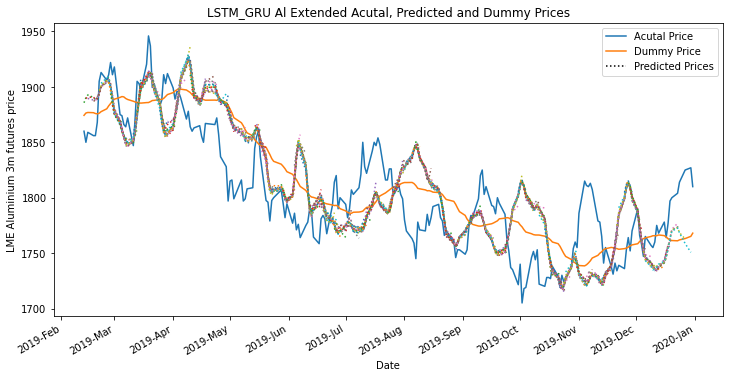

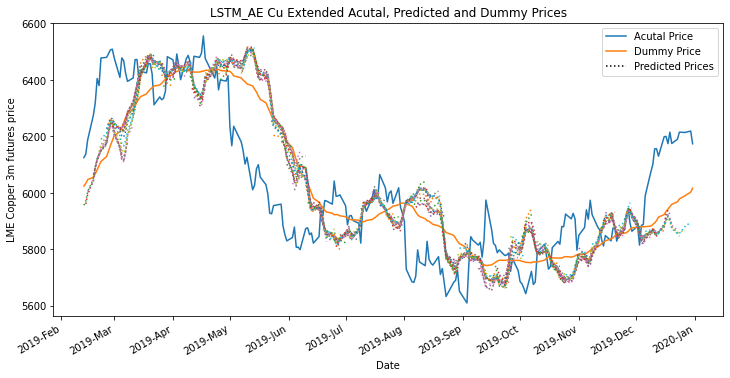

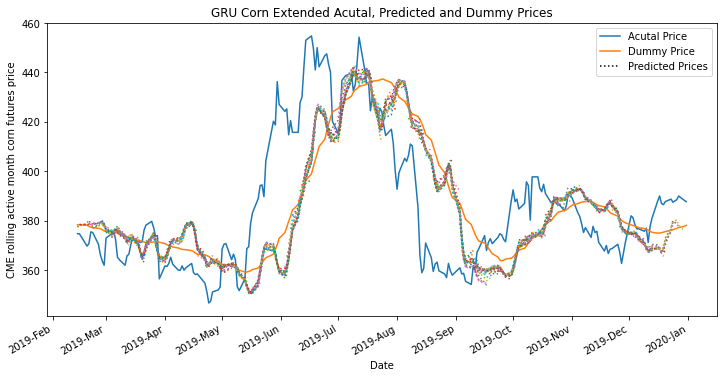

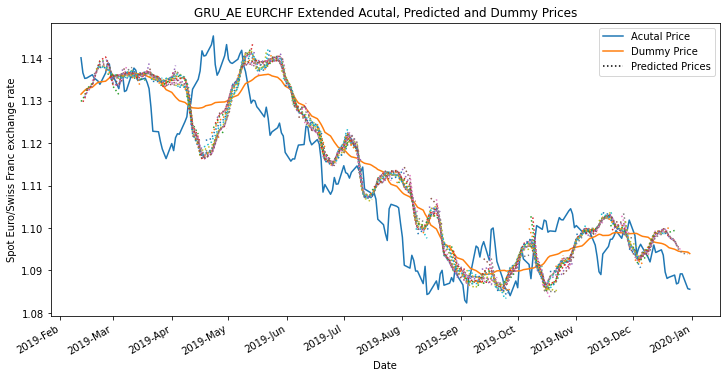

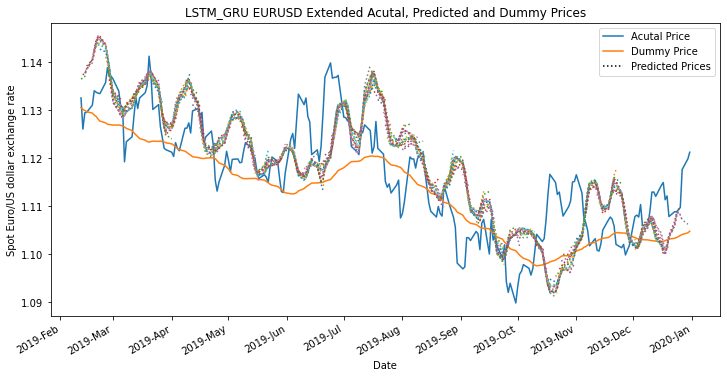

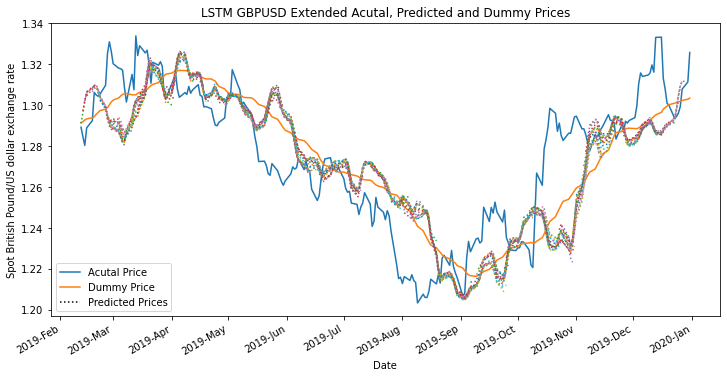

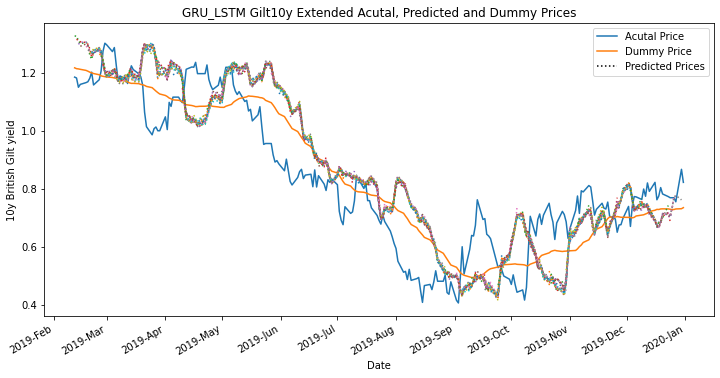

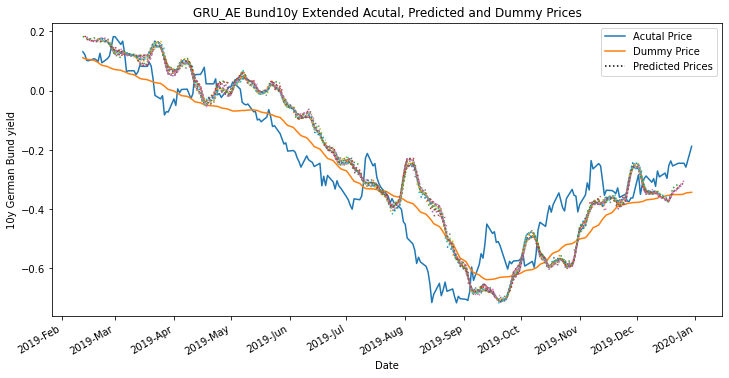

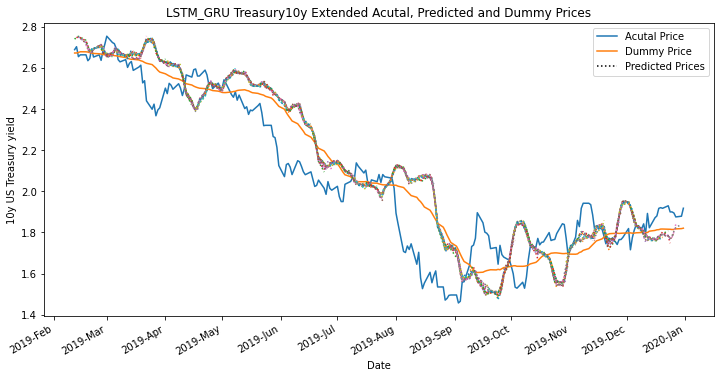

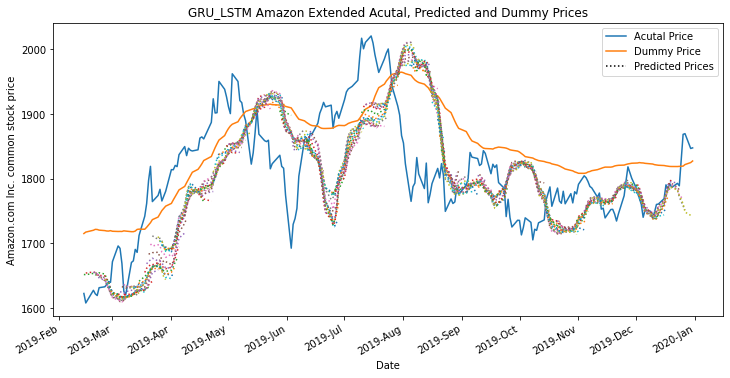

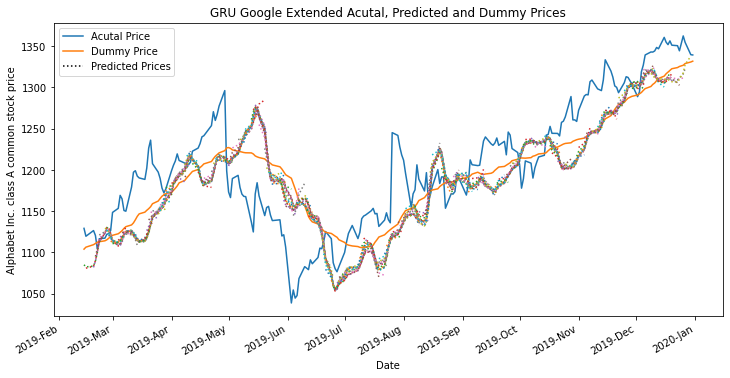

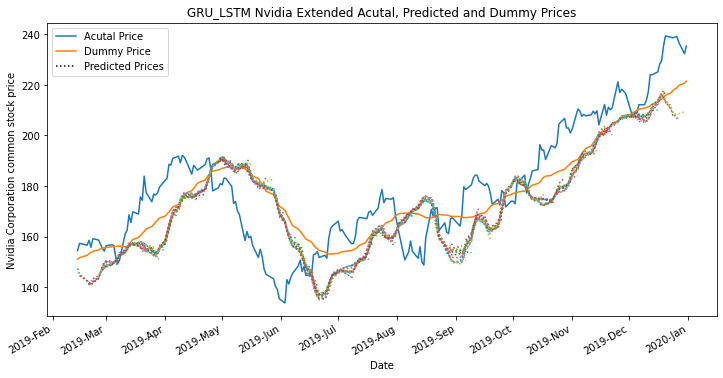

In [12]:
# creating lists to store the model name, security name, model metrics and dummy metrics
m_list = []
s_list = []
mse_list = []
rmse_list = []
mae_list = []

for s in security_list:
  # assinging the relevant value from optimal_dict
  model_str = optimal_dict[s]

  # clearing the keras session on the back end to ease memory usage
  K.clear_session()

  # loading the saved pre-trained model via a call to Trained_Model
  trained_model = Trained_Model(model_str, s)

  # removing the last layer
  trained_model.model.pop()
  # adding a new final layer, Dense with output_len units
  trained_model.model.add(Dense(output_len))

  # creating an instance of Data_Reader class
  in_data = Data_Reader(s, in_yr)
  # calling class method extract_train_test to generate training and test datasets
  in_data.extract_train_test()
  # calling class method extract_xy to generate X and y training and test datasets
  in_data.extract_xy_extended(window_len, output_len)

  # assigning X_train and y_train
  X_train = in_data.X_train
  y_train = in_data.y_train

  # assigning X_test and y_test
  X_test = in_data.X_test
  y_test = in_data.y_test

  # training the loaded model for 'epochs' additional epochs
  trained_model.train(X_train, y_train, epochs, batch_size)

  # dropping a dimension via np.squeeze to ensure compatability
  sk_y_test = np.squeeze(y_test, axis=2)

  # evaluating the loaded model
  mse, rmse, mae = trained_model.evaluate(X_test, sk_y_test)

  # creating an instance of Base_Model class using X_test
  base_model = Base_Model(X_test, window_len)
  # calling predict_y method
  base_model.predict_y(in_data.test_len - window_len)

  # using the model to predict y from X_test
  y_pred = trained_model.model.predict(X_test)
  # assigning y_dummy variable to .y_pred class attribute
  y_dummy = base_model.y_pred

  # calling class method extract_real_price to generate unnormalised prices
  in_data.extract_real_prices(y_pred, y_dummy)

  # assinging y_true variable
  y_true = in_data.y_true

  # assigning actual_price, predicted_price and dummy_price
  actual_price = in_data.actual_price
  predicted_price = in_data.predicted_price
  dummy_price = in_data.dummy_price


  plotter = Security_Plotter(in_data, actual_price, predicted_price,
                              dummy_price, in_data.train_len, window_len, s, model_str)

  plotter.single_plot_extended(output_len)

  # appending model metrics to relevant lists
  m_list.append(model_str)
  s_list.append(s)
  mse_list.append(mse)
  rmse_list.append(rmse)
  mae_list.append(mae)

  # assigning y_true variable for dummy metric calculation
  y_true = in_data.y_true

  # creating a string to save the model based on model name
  save_path = '/content/gdrive/My Drive/models_extended/'+model_str+'_'+s+'/'
  # making the relevant directory to store the model
  os.mkdir(save_path)
  # saving the model
  keras.models.save_model(trained_model.model, save_path+model_str+'_'+s+'_extended')
  # saving the model graph
  model_graph = plot_model(trained_model.model, to_file=save_path+model_str+'_extended_'+s+'_graph.png', show_shapes=True, expand_nested=True)
  # saving the matplotlib plot
  plotter.fig.savefig(save_path+model_str+'_'+s+'_extended_plot.png', bbox_inches='tight')
  # saving the error metrics as a text file
  error_file = open(save_path+model_str+'_'+s+'_extended_metrics.txt', 'w+')
  error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae))
  error_file.close()


  # finally clearing the output to keep notebook neat
  clear_output(wait=True)

# following successful completion of the loop, generating a dictionary of metrics
output_dict = {'Model': m_list,
          'Security': s_list,
          'MSE': mse_list,
          'RMSE': rmse_list,
          'MAE': mae_list}

# using output_dict to generate a dataframe
extended_df = pd.DataFrame(output_dict)

In [13]:
# displaying extended_df
extended_df

,Model,Security,MSE,RMSE,MAE
0,LSTM_GRU,Al,0.001241,0.035221,0.028256
1,LSTM_AE,Cu,0.001358,0.036855,0.028785
2,GRU,Corn,0.002087,0.045689,0.031923
3,GRU_AE,EURCHF,0.001140,0.033763,0.026594
4,LSTM_GRU,EURUSD,0.001110,0.033318,0.025827
5,LSTM,GBPUSD,0.001532,0.039142,0.029254
6,GRU_LSTM,Gilt10y,0.000477,0.021847,0.017403
7,GRU_AE,Bund10y,0.000360,0.018985,0.014856
8,LSTM_GRU,Treasury10y,0.000355,0.018835,0.014915
9,GRU_LSTM,Amazon,0.001327,0.036430,0.027699


In [14]:
extended_df.to_pickle('/content/gdrive/My Drive/extended_df/extended_output_dataframe.pkl')